In [22]:
%matplotlib widget
# %matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
import numpy as np
# import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import pickle

from Xana import Xana
from Xana import Soq
from glob import glob
import re

# import seaborn as sns
# import pandas as pd
# import h5py as h5
# import lmfit

# from lmfit.models import LinearModel
# from pathlib import Path
#plt.style.use('../nbstyle.mplstyle')

In [24]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'
datadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/'
anadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed'

# Analysis database

In [111]:
datafolder = 'water_gly_50_2'
datasetnumber = 2

# datafolder = 'apo_conc_gly_50_2'
# datasetnumber = 2

# datafolder = 'background'
# datasetnumber = 3

In [112]:
ana_db_files = glob(f'{anadir}/results/{datafolder}_{datasetnumber:04d}/p*/analysis_database.pkl')
ana_db_files

['/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/water_gly_50_2_0002/p339421/analysis_database.pkl']

In [113]:
d = Xana(fmtstr='ebs_id10_eiger500k', detector='eiger500k', 
            setupfile=f'{anadir}/mask-setup/setup-fullmask-cryo-230417.pkl',
            maskfile='../setups/cryo-mask-230417_03.npy'
           )

for i, f in enumerate(ana_db_files):
    if i == 0:
        d.load_db(f)
    else:
        d.append_db(f)

Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/water_gly_50_2_0002/p339421/analysis_database.pkl
Successfully loaded database


# SAXS

In [114]:
d.db['datdir'].loc[0]

PosixPath('/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/water_gly_50_2/water_gly_50_2_0002/scan0001')

In [115]:
def get_scan_number(s):
    s = str(s)
    s = re.search('(?<=scan)\d{4}', s)
    if s is not None:
        return int(s.group(0))
    else:
        return -1
    
def get_rep(x, reps_per_spot=1):
    scan = get_scan_number(x)
    rep = scan % reps_per_spot
    if rep == 0:
        rep = 4
    return rep

In [116]:
d.db['rep'] = d.db['master'].apply(lambda x: get_rep(x, reps_per_spot=4))
d.db['scannumber'] = d.db['datdir'].apply(lambda x: get_scan_number(str(x)))

In [117]:
len(d.db[(d.db['analysis'] == 'saxs')].index.values)

3

In [118]:
ind_saxs = d.db[(d.db['analysis'] == 'saxs')].index.values
# rep = 1
# ind_saxs = d.db[(d.db['analysis'] == 'saxs')
#                & (d.db['rep'] == rep)
#                 ].index.values

# ind_xpcs = d.db[(d.db['analysis'] == 'xpcs')].index.values
print(f"number of saxs analysis: {len(ind_saxs)}")
# print(f"number of xpcs analysis: {len(ind_xpcs)}")
# display(d.db.loc[ind_saxs])
d.db.loc[ind_saxs]

number of saxs analysis: 3


,use,sample,analysis,mod,savname,savfile,setupfile,comment,series,t_exposure,t_readout,nframes,master,first,last,datdir,rep,scannumber
0,True,,saxs,2023-06-28 14:24:55.922116,s0001_0000.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,1.0,0.1,0.000003,190.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/water_...,10.0,199.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/water_...,1,1
2,True,,saxs,2023-06-28 14:25:03.645504,s0002_0002.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,2.0,0.1,0.000003,190.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/water_...,10.0,199.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/water_...,2,2
4,True,,saxs,2023-06-28 14:25:10.773615,s0003_0004.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,3.0,0.1,0.000003,190.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/water_...,10.0,199.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/water_...,3,3


In [103]:
s = Soq(d)

In [104]:
tmp = d.get_item(ind_saxs[0])
tmp.keys()

dict_keys(['Isaxs', 'Vsaxs', 'soq'])

/tmp/ipykernel_27204/3053178934.py:9: RuntimeWarning: divide by zero encountered in log
  im2 = a2.imshow(np.log(image), vmin=-8, vmax=-1)


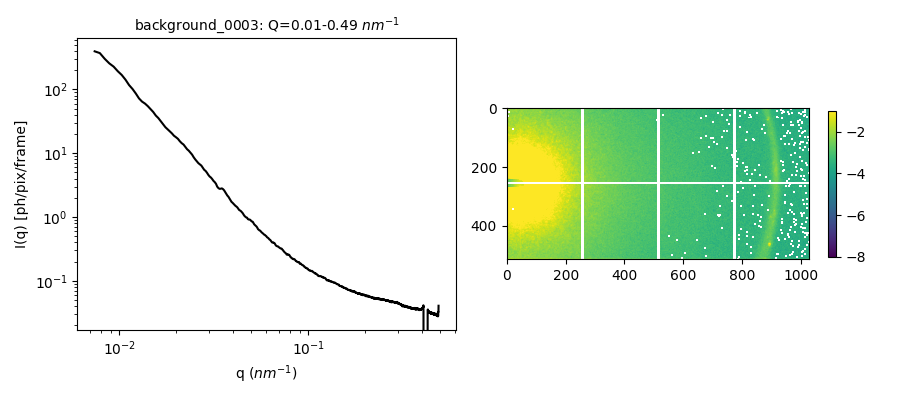

In [105]:
tmp = d.get_item(ind_saxs[0])
soq = tmp['soq']
image = tmp['Isaxs']

f,(a1,a2) = plt.subplots(1,2,figsize=(9,4), tight_layout=True)

a1.plot(soq[:,0], soq[:,1], '-k')

im2 = a2.imshow(np.log(image), vmin=-8, vmax=-1)
plt.colorbar(im2, ax=a2, shrink=0.5)

a1.set_title(f'{datafolder}_{datasetnumber:04d}: Q={soq[0,0]:.2f}-{soq[-1,0]:.2f} $nm^{{-1}}$', fontsize=10)
a1.set_xscale('log')
a1.set_yscale('log')
a1.set_xlabel('q ($nm^{-1}$)')
a1.set_ylabel('I(q) [ph/pix/frame]')
plt.show()

In [106]:
mask = np.load('/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/cryo-mask-230417_03.npy')

In [107]:
tmp = d.get_item(ind_saxs[0])
image = tmp['Isaxs']
framemax=3
for i in range(1,framemax):
    tmp = d.get_item(ind_saxs[i])
    image += tmp['Isaxs']

IndexError: index 1 is out of bounds for axis 0 with size 1

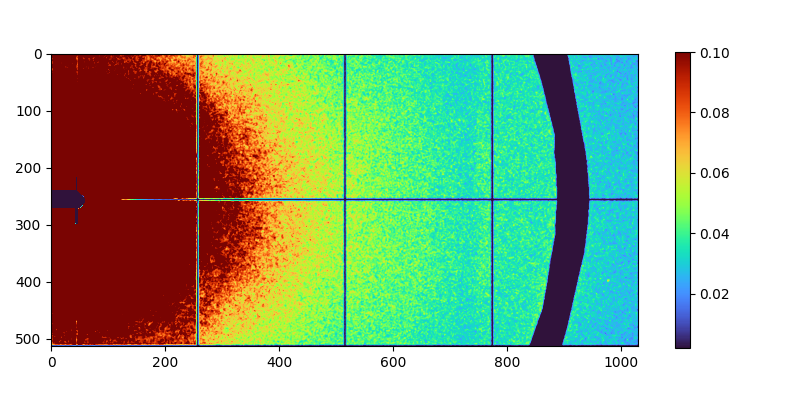

In [ ]:
f, a2 = plt.subplots(1,1,figsize=(8,4), tight_layout=True)
im2 = a2.imshow(image*mask, vmin=2e-3, vmax=.1, interpolation='bicubic',cmap='turbo')
plt.colorbar(im2, ax=a2, shrink=0.8)
plt.show()

## Average over all the scans

In [108]:
Iqs = []
qs = d.get_item(ind_saxs[0])['soq'][:,0]

for ind in ind_saxs[:100]:
    Iqs.append(d.get_item(ind)['soq'][:,1])
Iq_avg =  np.average(Iqs, axis=0)
# Iq_avg_per_spot = np.average(Iqs, axis=1)
print(np.shape(Iqs), np.shape(Iq_avg))

(1, 1000) (1000,)


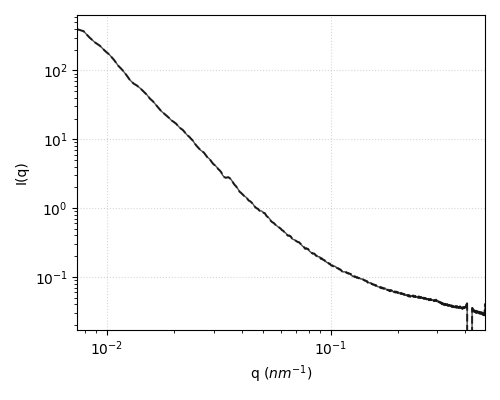

In [109]:
f, a1 = plt.subplots(1,1, tight_layout=True, figsize=(5,4))
col = plt.cm.copper(np.linspace(0,1,len(ind_saxs)))

for i in range(len(Iqs)):
    a1.plot(qs, Iqs[i], c=col[i], lw=1, alpha=.7, label=i) 
a1.plot(qs, Iq_avg, c='k', alpha=.7, ls='--') 
# a1.axvline(qs[30])
# a1.legend()
a1.set_xlim(qs[0],qs[-1])
# a1.set_title(f'{datafolder}_{datasetnumber:04d}: Q={soq[0,0]:.2f}-{soq[-1,0]:.2f} $nm^{{-1}}$', fontsize=10)
a1.set_xscale('log')
a1.set_yscale('log')
a1.set_xlabel('q ($nm^{-1}$)')
a1.set_ylabel('I(q)')
# a1.set_xlim(0.1,0.4)
# a1.set_ylim(1e-2,3e-2)
a1.grid(ls=':', alpha=.5)

/cfs/home/mabi3848/id10-ferritin-2022/01-notebooks


In [110]:
# np.savez(f'../03-source/bkg_{datafolder}_{datasetnumber:04d}', Iq=Iq_avg, q=qs)

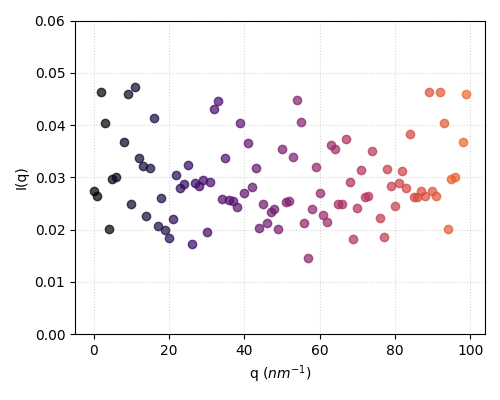

In [61]:
f, a1 = plt.subplots(1,1, tight_layout=True, figsize=(5,4))
col = plt.cm.inferno(np.linspace(0,1,len(ind_saxs)))

for i in range(len(Iqs)):
    a1.plot(i, Iqs[i][20], ls='', marker='o', alpha=.7, label=i, c=col[i]) 

# a1.legend()
a1.set_ylim(0,0.06)
# a1.set_title(f'{datafolder}_{datasetnumber:04d}: Q={soq[0,0]:.2f}-{soq[-1,0]:.2f} $nm^{{-1}}$', fontsize=10)
a1.set_xlabel('q ($nm^{-1}$)')
a1.set_ylabel('I(q)')
# a1.set_xlim(0.1,0.4)
# a1.set_ylim(1e-2,3e-2)
a1.grid(ls=':', alpha=.5)

In [41]:
Iq_bkg.shape

(1000,)

In [54]:
# np.savez("../03-source/backgrounds", Iq=Iqs, q=qs)

In [55]:
!ls ../03-source

backgrounds.npz
elog
ferritin_conc_gly_50_4_0002_0002_scan0001_g2.npy
ferritin_conc_gly_50_4_0002_scan0001_avg_g2.npy
water_gly_50_0002_scan0001_avg.npy
water_gly_50_0002_scan0001.npy
